In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
import statsmodels.formula.api as smf
from sklearn import linear_model, neighbors, cross_validation, grid_search
import datetime as datetime
from pylab import plotfile, show, gca
import matplotlib.cbook as cbook
import pylab as pl
from statsmodels.graphics.tsaplots import plot_acf

pd.set_option('display.max_rows', 35)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 10)

%matplotlib inline

plt.style.use('ggplot')

/Users/RyanReiger/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [4]:
df = pd.read_csv('/Users/RyanReiger/GA_Stuff/Final_Project/Project_DB_Update.csv')

In [5]:
#renaming columns
df = df.rename(columns={'NYSE_%Spread': 'NYSE_Spread_bps'})
df = df.rename(columns={'NYSE_%Range': 'NYSE_pct_range'})
df = df.rename(columns={'NYSE_%Spread': 'NYSE_Spread_bps'})
df = df.rename(columns={'Spread_$':'Spread_Dollar'})
df = df.rename(columns={'NAV ': 'NAV'})
#formatting Date and Fund Inception columns
df.Date = pd.to_datetime(df.Date)
df.Inception = pd.to_datetime(df.Inception)
#Transforming Varables
df['Ask_Val'] = df['NYSE_Ask_Size'] * df['NYSE_VWAP']
df['Bid_Val'] = df['NYSE_Bid_Size'] * df['NYSE_VWAP']
df['Vintage'] = df.Date - df.Inception
df['AUM'] = df.Shares_Outstanding * df.NAV * 1000
#Formatting Vintage Varable
df.Vintage = df.Vintage.astype('timedelta64[D]')
df.ix[df.Vintage == 0, 'Vintage'] = 1
#Creating my dependent variable
df['Asset_Velocity'] = df.AUM / (df.Vintage * 1.0)
#Dropping Variables
df = df.drop('Spread_bps', 1)
df = df.drop('Spread_Dollar', 1)
#Transformation
df.Asset_Velocity = df.Asset_Velocity.astype(float)
df = df.drop('Price_Change', 1)
df['Log_Asset_Velocity'] = np.log(df.Asset_Velocity)
df['Log_Dollar_Volume'] = np.log(df.Dollar_Volume)
df['Premium_Discount_Adj'] = df.Premium_Discount + 1
df['Log_Premium_Discount'] = np.log(df.Premium_Discount_Adj)
df['Log_NYSE_Spread_bps'] = np.log(df.NYSE_Spread_bps)
df['Log_Ask_Val'] = np.log(df.Ask_Val)
df['Log_Bid_Val'] = np.log(df.Bid_Val)

In [6]:
#Indexing the date
df.set_index('Date', inplace = True)
df['Year'] = df.index.year
df['Month'] = df.index.month


In [7]:
#Splitting Data Frames
df_EEM = df[df.Fund == "EEM"]
df_VWO = df[df.Fund == "VWO"]
df_IEMG = df[df.Fund == "IEMG"]
df_SCHE = df[df.Fund == "SCHE"]

In [8]:
#Auto Corralate
df_EEM.Asset_Velocity.resample('D', how = 'mean').autocorr(lag = 20)

0.94953725542212997

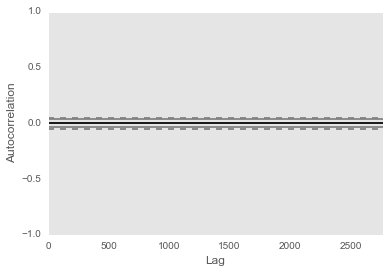

In [9]:
pd.tools.plotting.autocorrelation_plot(df_EEM.NYSE_Spread_bps)

In [10]:
df.columns

Index([u'Fund', u'Close_Price', u'High_Price', u'Low_Price', u'NAV',
       u'Premium_Discount', u'Volume', u'Dollar_Volume', u'Fund_Flow',
       u'Shares_Outstanding', u'Inception', u'NYSE_MKT_SHR', u'NYSE_VOLUME',
       u'NYSE_Dollar_Volume', u'NYSE_Intraday_Volatility',
       u'NYSE_Daily_Volatility', u'NYSE_Close', u'NYSE_VWAP', u'NYSE_Range',
       u'NYSE_pct_range', u'NYSE_Spread', u'NYSE_Spread_bps', u'NYSE_Bid_Size',
       u'NYSE_Ask_Size', u'NYSE_Average_Size', u'Ask_Val', u'Bid_Val',
       u'Vintage', u'AUM', u'Asset_Velocity', u'Log_Asset_Velocity',
       u'Log_Dollar_Volume', u'Premium_Discount_Adj', u'Log_Premium_Discount',
       u'Log_NYSE_Spread_bps', u'Log_Ask_Val', u'Log_Bid_Val', u'Year',
       u'Month'],
      dtype='object')

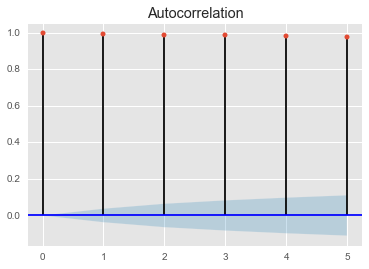

In [75]:
plot = plot_acf(df_EEM.Close_Price, lags = 5)

In [12]:
df.dropna(subset=['NAV'], inplace=True)
df.dropna(subset=['Asset_Velocity'], inplace=True)
df.Fund_Flow = df.Fund_Flow.fillna(0)
df.dropna(subset=['NYSE_Close'], inplace=True)

In [13]:
df.Asset_Velocity = df.Asset_Velocity.astype(float)


In [65]:
df_EEM.isnull().sum()

Fund                        0
Close_Price                 0
High_Price                  0
Low_Price                   0
NAV                         0
Premium_Discount            1
Volume                      0
Dollar_Volume               0
Fund_Flow                   1
Shares_Outstanding          1
Inception                   0
NYSE_MKT_SHR                2
NYSE_VOLUME                 2
NYSE_Dollar_Volume          2
NYSE_Intraday_Volatility    2
NYSE_Daily_Volatility       2
NYSE_Close                  2
                           ..
NYSE_Bid_Size               2
NYSE_Ask_Size               2
NYSE_Average_Size           2
Ask_Val                     2
Bid_Val                     2
Vintage                     0
AUM                         1
Asset_Velocity              1
Log_Asset_Velocity          1
Log_Dollar_Volume           0
Premium_Discount_Adj        1
Log_Premium_Discount        1
Log_NYSE_Spread_bps         2
Log_Ask_Val                 2
Log_Bid_Val                 2
Year      

In [66]:
df_EEM.dropna(subset=['Asset_Velocity'], inplace=True)


/Users/RyanReiger/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [72]:
model = sm.tsa.arima_model.ARMA(df_EEM.Asset_Velocity.astype(float), (1, 4)).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:         Asset_Velocity   No. Observations:                 2768
Model:                     ARMA(1, 4)   Log Likelihood              -37282.260
Method:                       css-mle   S.D. of innovations         170927.762
Date:                Sun, 01 May 2016   AIC                          74578.521
Time:                        15:37:00   BIC                          74620.002
Sample:                    01-03-2005   HQIC                         74593.502
                         - 12-31-2015                                         
========================================================================================
                           coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
const                 1.084e+07   1.57e+06      6.913      0.000      7.77e+06  1.39e+07
ar.L1.Asset_Velocity     0.9970      0.002    594.677      0.000         0.994     1.000
ma.L1.Asset_Velocity     0.2709      0.019     14.275      0.000         0.234     0.308
ma.L2.Asset_Velocity     0.1207      0.020      6.066      0.000         0.082     0.160
ma.L3.Asset_Velocity     0.0652      0.021      3.153      0.002         0.025     0.106
ma.L4.Asset_Velocity     0.0562      0.019      3.002      0.003         0.020     0.093
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0030           +0.0000j            1.0030            0.0000
MA.1            0.9968           -1.7915j            2.0501           -0.1692
MA.2            0.9968           +1.7915j            2.0501            0.1692
MA.3           -1.5771           -1.3211j            2.0573           -0.3890
MA.4           -1.5771           +1.3211j            2.0573            0.3890
-----------------------------------------------------------------------------
"""

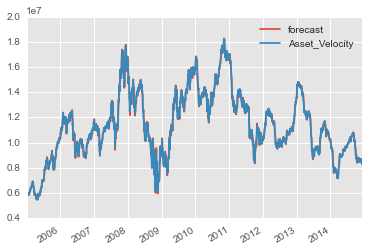

In [80]:
plot = model.plot_predict(5, 2500)